<a href="https://colab.research.google.com/github/alexiadb/Application-de-diagnostic-de-maladie-cardiaque/blob/main/Simplon_Cardiaque_corrig%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import missingno as msno
import seaborn as sns
%matplotlib inline

from sklearn import decomposition, preprocessing

In [ ]:
# lecture CSV
df = pd.read_csv("Data/cardiaque.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AGE          918 non-null    int64  
 1   SEXE         918 non-null    object 
 2   TDT          918 non-null    object 
 3   PAR          918 non-null    int64  
 4   CHOLESTEROL  918 non-null    int64  
 5   GAJ          918 non-null    int64  
 6   ECG          918 non-null    object 
 7   FCMAX        918 non-null    int64  
 8   ANGINE       918 non-null    object 
 9   DEPRESSION   918 non-null    float64
 10  PENTE        918 non-null    object 
 11  CŒUR         918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
df.describe().round(3)

,AGE,PAR,CHOLESTEROL,GAJ,FCMAX,DEPRESSION,CŒUR
count,918.000,918.000,918.000,918.000,918.000,918.000,918.000
mean,53.511,132.397,198.800,0.233,136.809,0.887,0.553
std,9.433,18.514,109.384,0.423,25.460,1.067,0.497
min,28.000,0.000,0.000,0.000,60.000,-2.600,0.000
25%,47.000,120.000,173.250,0.000,120.000,0.000,0.000
50%,54.000,130.000,223.000,0.000,138.000,0.600,1.000
75%,60.000,140.000,267.000,0.000,156.000,1.500,1.000
max,77.000,200.000,603.000,1.000,202.000,6.200,1.000


<AxesSubplot:>

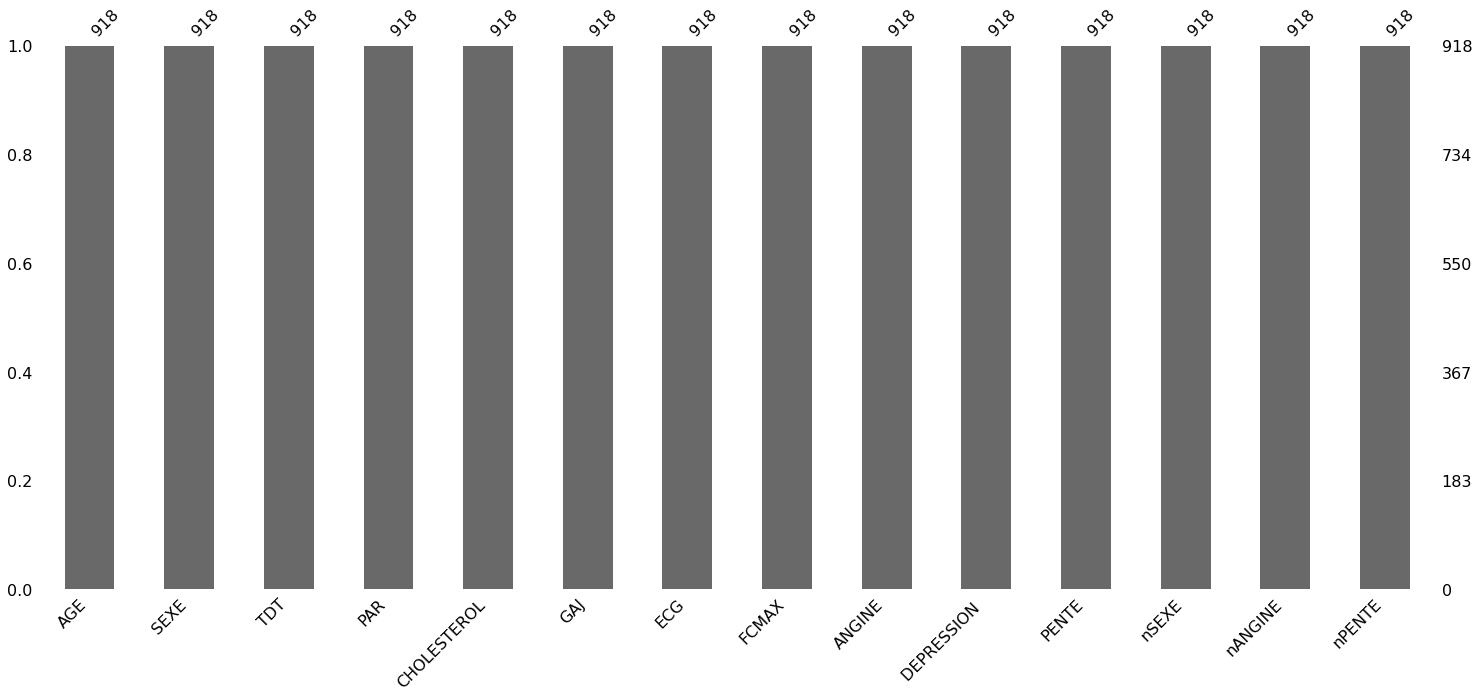

In [ ]:
msno.bar(df)

CPU times: user 4.25 s, sys: 358 ms, total: 4.61 s
Wall time: 4.26 s


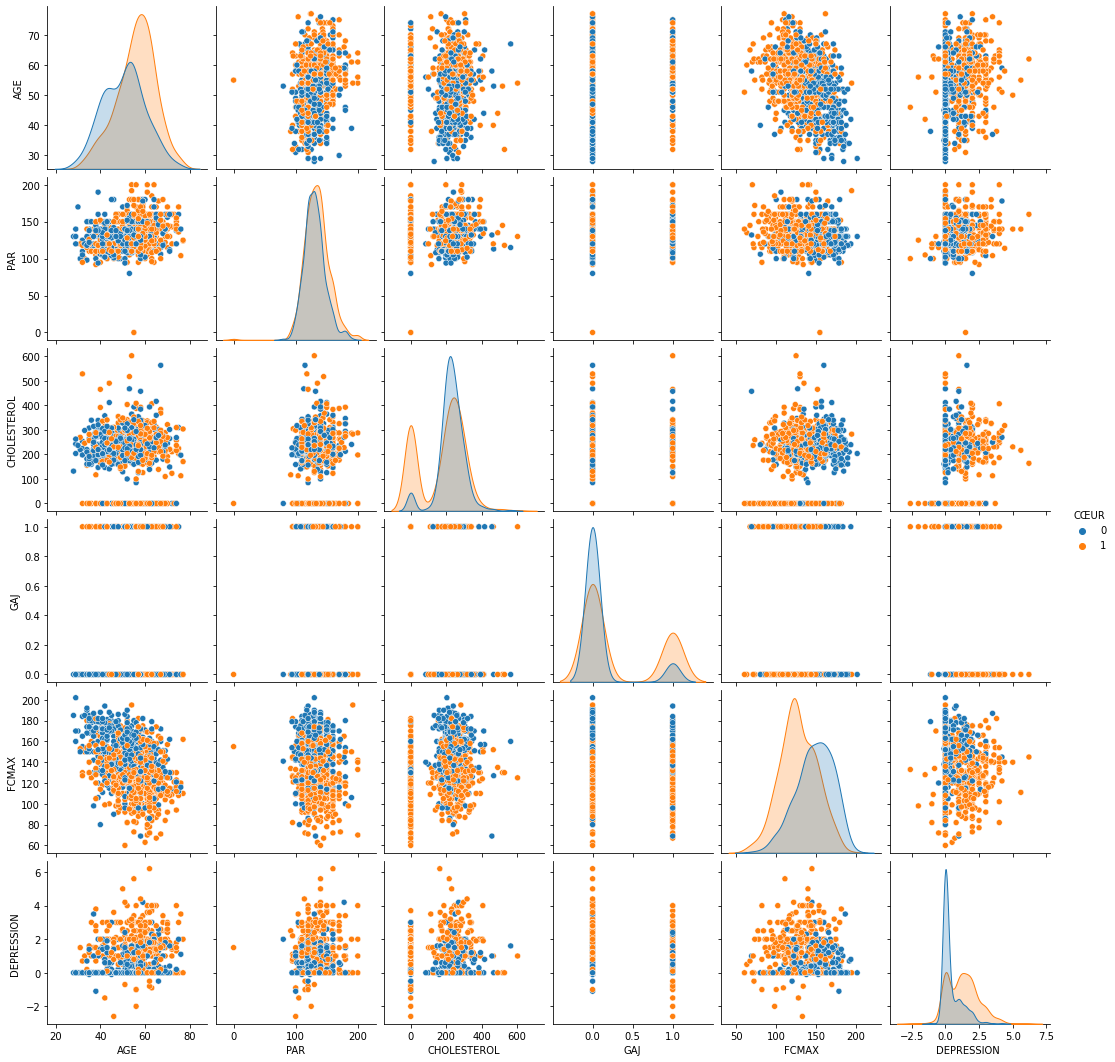

In [ ]:
%%time
# Analyse bivariée
sns.pairplot(df, hue = 'CŒUR')

In [ ]:
# Extraction des colonnes numériques & catégoriques

if 'CŒUR' in df.columns:
    target=df.CŒUR
    df = df.drop(columns=['CŒUR'])

# Collonne 'binaires'
df['nSEXE'] = (df['SEXE']=='homme').astype(int)
df['nANGINE'] = (df['ANGINE']=='Oui').astype(int)
df['nPENTE'] = df['PENTE'].map({'Ascendant': +1, 'Plat': 0, 'Descendant': -1})

dfCat = df.select_dtypes(include=['object'])
XCat = dfCat.columns.values

dfNum = df.select_dtypes(include=['int64', 'float64'])
XNum = dfNum.columns.values

for cat in XCat:
    print('Cat', cat, df[cat].unique())

print(dfNum.columns)
df.dtypes

Cat SEXE ['homme' 'femme']
Cat TDT ['AA' 'DNA' 'ASY' 'AT']
Cat ECG ['Normal' 'ST' 'LVH']
Cat ANGINE ['Non' 'Oui']
Cat PENTE ['Ascendant' 'Plat' 'Descendant']
Index(['AGE', 'PAR', 'CHOLESTEROL', 'GAJ', 'FCMAX', 'DEPRESSION ', 'nSEXE',
       'nANGINE', 'nPENTE'],
      dtype='object')


AGE              int64
SEXE            object
TDT             object
PAR              int64
CHOLESTEROL      int64
GAJ              int64
ECG             object
FCMAX            int64
ANGINE          object
DEPRESSION     float64
PENTE           object
nSEXE            int64
nANGINE          int64
nPENTE           int64
dtype: object

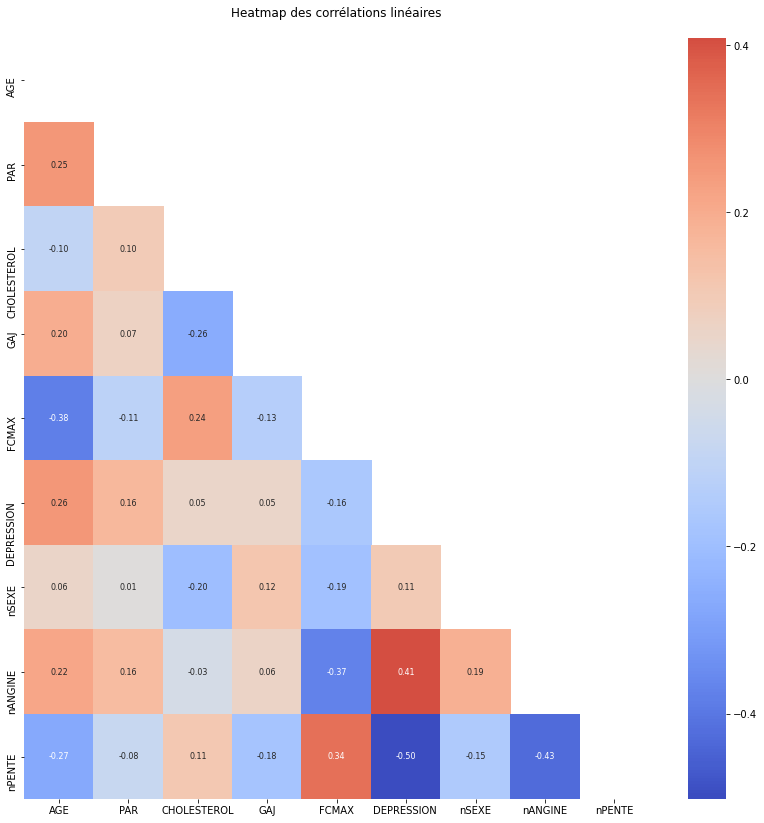

,AGE,PAR,CHOLESTEROL,GAJ,FCMAX,DEPRESSION,nSEXE,nANGINE,nPENTE
AGE,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.258612,0.055750,0.215793,-0.268264
PAR,0.254399,1.000000,0.100893,0.070193,-0.112135,0.164803,0.005133,0.155101,-0.075162
CHOLESTEROL,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.050148,-0.200092,-0.034166,0.111471
GAJ,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.052698,0.120076,0.060451,-0.175774
FCMAX,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.160691,-0.189186,-0.370425,0.343419
DEPRESSION,0.258612,0.164803,0.050148,0.052698,-0.160691,1.000000,0.105734,0.408752,-0.501921
nSEXE,0.055750,0.005133,-0.200092,0.120076,-0.189186,0.105734,1.000000,0.190664,-0.150693
nANGINE,0.215793,0.155101,-0.034166,0.060451,-0.370425,0.408752,0.190664,1.000000,-0.428706
nPENTE,-0.268264,-0.075162,0.111471,-0.175774,0.343419,-0.501921,-0.150693,-0.428706,1.000000


In [ ]:
# Matrice de corrélation
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(14,14))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, 
                 center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", color='black')
plt.show()
corr

variances [0.92030948 0.04913229]


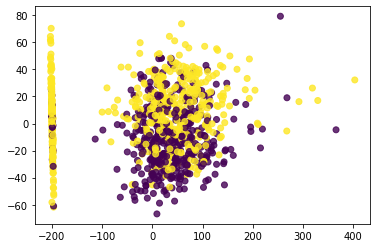

In [ ]:
# PCA brute
# reprise https://fxjollois.github.io/cours-2016-2017/analyse-donnees-massives-tp6.html
n_components=2
pca=decomposition.PCA(n_components=n_components)
X2=pca.fit_transform(dfNum)
print('variances', pca.explained_variance_ratio_)
plt.scatter(X2[:, 0], X2[:, 1], c=target, alpha=0.8, label='PCA')

In [ ]:
# Mise à l'échelle des info

dfNumScaled = preprocessing.scale(dfNum)
pd.DataFrame(dfNumScaled, columns=dfNum.columns).describe().round(3)

,AGE,PAR,CHOLESTEROL,GAJ,FCMAX,DEPRESSION,nSEXE,nANGINE,nPENTE
count,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000,918.000
mean,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000
std,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001
min,-2.706,-7.155,-1.818,-0.551,-3.018,-3.271,-1.938,-0.824,-2.244
25%,-0.691,-0.670,-0.234,-0.551,-0.661,-0.832,0.516,-0.824,-0.596
50%,0.052,-0.130,0.221,-0.551,0.047,-0.270,0.516,-0.824,-0.596
75%,0.688,0.411,0.624,-0.551,0.754,0.575,0.516,1.214,1.052
max,2.492,3.653,3.697,1.814,2.562,4.984,0.516,1.214,1.052


In [ ]:
pca = decomposition.PCA()
pca.fit(dfNumScaled)

print('variances expliquées (explained_variance_) par chaque dimension')
print(pca.explained_variance_)
print('ratio (proportion) de variance expliquée par dimension (explained_variance_ratio_)')
print(pca.explained_variance_ratio_)

variances expliquées (explained_variance_) par chaque dimension
[2.59005792 1.37592801 1.09141609 0.88533585 0.85670204 0.65562054
 0.63011487 0.50680174 0.41783755]
ratio (proportion) de variance expliquée par dimension (explained_variance_ratio_)
[0.28747072 0.15271435 0.12113635 0.09826349 0.09508542 0.07276737
 0.0699365  0.05624996 0.04637582]


In [ ]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(dfNum.shape[1])], 
        "Valeur propre" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    },
    columns = ["Dimension", "Valeur propre", "% variance expliquée", "% cum. var. expliquée"]
)
eig

,Dimension,Valeur propre,% variance expliquée,% cum. var. expliquée
0,Dim1,2.590058,29.0,29.0
1,Dim2,1.375928,15.0,44.0
2,Dim3,1.091416,12.0,56.0
3,Dim4,0.885336,10.0,66.0
4,Dim5,0.856702,10.0,75.0
5,Dim6,0.655621,7.0,83.0
6,Dim7,0.630115,7.0,90.0
7,Dim8,0.506802,6.0,95.0
8,Dim9,0.417838,5.0,100.0


Text(7, 12, '11%')

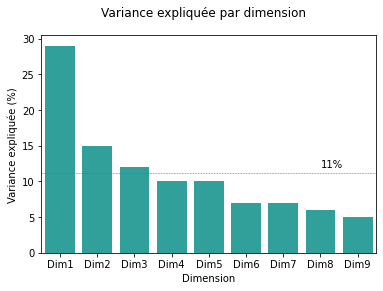

In [ ]:
g_eig = sns.barplot(x = "Dimension", 
                y = "% variance expliquée",
                palette = ["lightseagreen"],
                data = eig)
g_eig.set(ylabel = "Variance expliquée (%)")
g_eig.figure.suptitle("Variance expliquée par dimension")
plt.axhline(y = 100/dfNum.shape[1], linewidth = .5, color = "dimgray", linestyle = "--")
plt.text(7, 12, f"{100/dfNum.shape[1]:.0f}%")

In [ ]:
cardio_pca = pca.transform(dfNumScaled)

dfPca = pd.DataFrame({
    "Dim1" : cardio_pca[:,0], 
    "Dim2" : cardio_pca[:,1], 
    "Coeur" : target
})
dfPca

,Dim1,Dim2,Coeur
0,-2.307849,-0.370758,0
1,-0.750267,-1.271516,1
2,-1.335092,0.338443,0
3,0.752049,-1.322541,1
4,-0.713149,0.310625,0
...,...,...,...
913,-0.554893,-0.021532,1
914,1.970680,-0.053479,1
915,1.461053,0.127897,1
916,-1.484702,-0.906216,1


Text(0.5, 0.98, 'Premier plan factoriel')

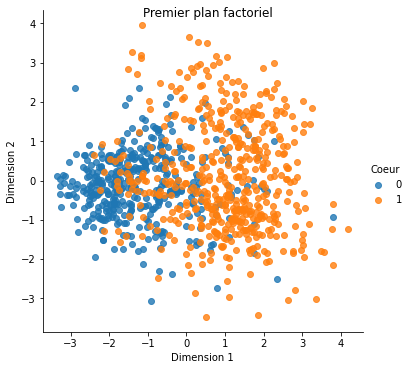

In [ ]:
g_pca = sns.lmplot(x="Dim1", y="Dim2", hue = "Coeur", data = dfPca, fit_reg = False)
g_pca.set(xlabel = "Dimension 1", ylabel = "Dimension 2")
g_pca.fig.suptitle("Premier plan factoriel")